In [184]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy.matlib
from matplotlib.widgets import Slider
from mpl_toolkits.mplot3d import Axes3D
from ipywidgets import interact, IntSlider, fixed

In [185]:
from ratinabox.Environment import Environment
from ratinabox.Agent import Agent

In [186]:
from network_utils1004 import (
    gaussian, create3Dplot, create2Dplot, show_slice,
    plot_all_sensory_fields, plot_sensory_input_subplots,
    plot_initial_activation, plot_normalised_sensory_grid,
    plot_final_activation, generate_evenly_spaced_centers,
    generate_circular_trajectory, generate_edge_to_edge_trajectory,
    plot_trajectory_over_PC_idx, plot_trajectory_over_PC_idx, view_bump_with_slider_3D, 
    show_bump_3D, plot_maze_over_PC_idx
)

In [187]:
# === Step 1: Initialise network parameters and matrices === #

# Grid and network dimensions
rows = 10
cols = 10
nCells = rows * cols

# Sensory and recurrent configuration
nSensoryCells = 50
Sigma = 2.5                 # Spread of the Gaussian tuning curve
NetThreshold = 0.7       # Threshold for activation
nIterationsPerTimestep = 10  # Recurrent iterations per timestep
blend_factor = 0.9          # Influence of new input vs. previous state

# Allocate memory for the recurrent weight matrix
weightsMat = np.zeros((rows, cols, nCells))

# Create an index grid for place cells
PC_idx = np.arange(nCells).reshape(rows, cols)

In [188]:
# Maze parameters
n_arms = 8
arm_length = 0.48        # How far arms extend
arm_width = 0.1        # Width of arms
gap = 0.12               # Gap at center to avoid wall overlap
center = np.array([0.5, 0.5])  # Center of environment

angles = np.linspace(2 * np.pi, 0, n_arms, endpoint=False)
walls = []

# Set the first point
angle0 = angles[0]
arm_dir = np.array([np.cos(angle0), np.sin(angle0)])
offset = np.array([-np.sin(angle0), np.cos(angle0)]) * (arm_width / 2)
start0 = center + arm_dir * gap + offset
walls.append([round(start0[0], 2), round(start0[1], 2)])  # Start point of first arm

for angle in angles:
    arm_dir = np.array([np.cos(angle), np.sin(angle)])
    offset = np.array([-np.sin(angle), np.cos(angle)]) * (arm_width / 2)

    # Start/end points with gap
    end1 = center + arm_dir * arm_length + offset
    start2 = center + arm_dir * gap - offset
    end2 = center + arm_dir * arm_length - offset

    # walls.append(end1.tolist())
    # walls.append(end2.tolist())
    # walls.append(start2.tolist())

    walls.append([round(end1[0], 2), round(end1[1], 2)])
    walls.append([round(end2[0], 2), round(end2[1], 2)])
    walls.append([round(start2[0], 2), round(start2[1], 2)])

env = Environment(params={
    "boundary": walls,  # full square
    "boundary_conditions": "solid",
})

#plot_maze_over_PC_idx(env, PC_idx)

Unique positions visited: 600


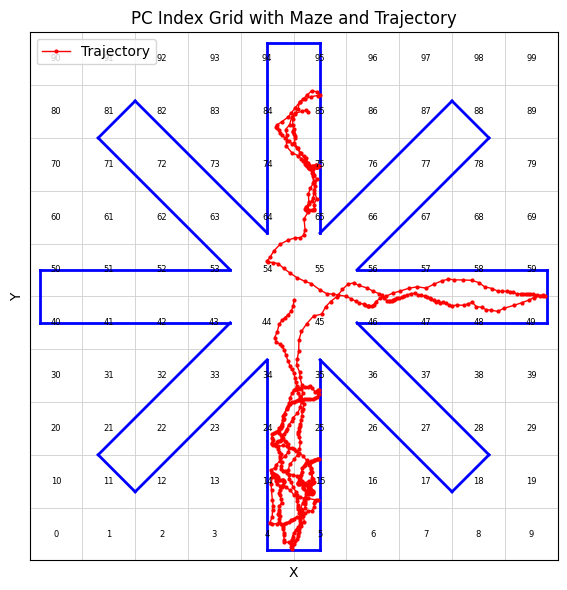

(<Figure size 240x240 with 1 Axes>, <Axes: >)

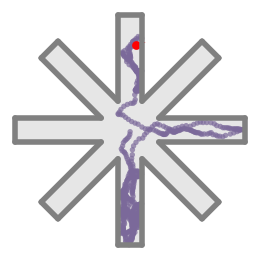

In [189]:
# === Step 3: Create agent and simulate motion === #
agent = Agent(env)

agent.pos = center.copy()
agent.speed_mean = 0.08 #m/s
agent.speed_coherence_time = 0.7
agent.rotation_velocity_std = 120 * np.pi/180 #radians 
agent.rotational_velocity_coherence_time = 0.08

# Simulate for 10 seconds (100 steps)
T = 60.0
dt = 0.1
for _ in range(int(T / dt)):
    agent.update(dt=dt)


positions = np.array(agent.history["pos"])*10

print(f"Unique positions visited: {np.unique(positions, axis=0).shape[0]}")

def plot_pc_grid_maze_trajectory(PC_idx, env, trajectory, maze_color='blue', traj_color='red', lw=2):
    """
    Plot the PC index grid as outlined squares with index labels,
    overlay maze walls, and plot trajectory.
    """
    rows, cols = PC_idx.shape
    fig, ax = plt.subplots(figsize=(6, 6))

    # Plot outlined squares and PC indices
    for r in range(rows):
        for c in range(cols):
            rect = plt.Rectangle((c, r), 1, 1, fill=False, edgecolor='lightgrey', linewidth=0.5)
            ax.add_patch(rect)
            ax.text(c + 0.5, r + 0.5, str(PC_idx[r, c]), ha='center', va='center',
                    fontsize=6, color='black')

    # Plot maze walls scaled to PC grid
    for wall in env.walls:
        (x0, y0), (x1, y1) = wall
        x0_scaled, x1_scaled = x0 * cols, x1 * cols
        y0_scaled, y1_scaled = y0 * rows, y1 * rows
        ax.plot([x0_scaled, x1_scaled], [y0_scaled, y1_scaled],
                color=maze_color, linewidth=lw)

    # Plot trajectory
    xs, ys = zip(*trajectory)
    ax.plot(xs, ys, color=traj_color, marker='o', markersize=2,
            linewidth=1, label='Trajectory')

    ax.set_title("PC Index Grid with Maze and Trajectory")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_xlim(0, cols)
    ax.set_ylim(0, rows)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.legend(loc='upper left')
    ax.set_aspect('equal')
    plt.tight_layout()
    plt.show()

# Plot it all
plot_pc_grid_maze_trajectory(PC_idx, env, positions)

agent.plot_trajectory()


In [190]:
# Convert continuous positions to discrete PC grid coordinates
pos_indices = np.clip(positions.astype(int), 0, 9)  # ensure indices stay within bounds
pc_indices = [PC_idx[y, x] for x, y in pos_indices]  # PC_idx is indexed [row, col] = [y, x]

# === Debug prints for indexing verification ===
print("Shape of positions array:", positions.shape)
print("First 5 positions:\n", positions[:5])
print("First 5 grid indices:\n", pos_indices[:5])
print("First 5 PC indices:", pc_indices[:5])

print("Last 5 positions:\n", positions[-5:])
print("Last 5 grid indices:\n", pos_indices[-5:])
print("Last 5 PC indices:", pc_indices[-5:])

print(f"Unique PC indices visited: {len(set(pc_indices))}")

Shape of positions array: (600, 2)
First 5 positions:
 [[5.00448559 4.92843825]
 [4.99324868 4.81858921]
 [4.95387561 4.71847997]
 [4.89128444 4.65152188]
 [4.83652658 4.5974507 ]]
First 5 grid indices:
 [[5 4]
 [4 4]
 [4 4]
 [4 4]
 [4 4]]
First 5 PC indices: [45, 44, 44, 44, 44]
Last 5 positions:
 [[4.96145842 8.38926337]
 [5.02630807 8.46620083]
 [5.15691511 8.50407004]
 [5.23194952 8.52692529]
 [5.2648057  8.49972208]]
Last 5 grid indices:
 [[4 8]
 [5 8]
 [5 8]
 [5 8]
 [5 8]]
Last 5 PC indices: [84, 85, 85, 85, 85]
Unique PC indices visited: 26


# Load the data
data = np.load("sargolini.npz")
positions = data['pos']   # shape: (T, 2)
times = data['t']

# Limit to first 50 timesteps
positions = positions[:1000]

# Convert continuous positions to discrete grid indices
x_norm = np.clip((positions[:, 0] * cols).astype(int), 0, cols - 1)
y_norm = np.clip((positions[:, 1] * rows).astype(int), 0, rows - 1)

# Create trajectory as list of (row, col)
trajectory_positions = list(zip(y_norm, x_norm))

# Plot the trajectory over the place cell grid
plot_trajectory_over_PC_idx(trajectory_positions, PC_idx)

In [191]:
# === Step 2: Initialise the recurrent weights matrix === #
# Each cell has a weight of 1 with itself and 0.5 with its immediate neighbours

weightsMat = np.zeros((rows, cols, nCells))  # Reset in case already defined

for k in range(nCells):
    # Get the (row, col) location of the k-th place cell
    r, c = np.where(PC_idx == k)
    r, c = r[0], c[0]

    # Assign weight of 1 to itself
    weightsMat[r, c, k] = 1.0

    # Assign weight of 0.5 to immediate neighbors (up, down, left, right)
    for dr, dc in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
        nr, nc = r + dr, c + dc
        if 0 <= nr < rows and 0 <= nc < cols:
            weightsMat[nr, nc, k] = 0.5

In [192]:
# Step 4: Create a sheet of sensory cells with Gaussian firing fields
SensoryFiringFields = np.zeros((rows, cols, nSensoryCells))

# Generate center positions
centers = generate_evenly_spaced_centers(rows, cols, nSensoryCells)

# Create coordinate grid
X, Y = np.meshgrid(np.arange(rows), np.arange(cols))

# Compute Gaussian firing fields
for i, (cx, cy) in enumerate(centers):
    SensoryFiringFields[:, :, i] = gaussian(X, Y, cx, cy, Sigma)

# Plot all sensory fields using the saved utility function
plot_all_sensory_fields(SensoryFiringFields, PC_idx)

In [193]:
# STEP 5: Create a weights matrix between the sensory cells and attractor cells
sensoryWeights = np.zeros((nSensoryCells, nCells))

# Iterate over each place cell
for cell in range(nCells):
    r, c = np.where(PC_idx == cell) # find the position of the cell in the PC sheet

    # Extract firing rates from all sensory cells at this location
    sensoryWeights[:, cell] = SensoryFiringFields[r, c,:]


print("sensory Weights matrix shape:", sensoryWeights.shape)

sensory Weights matrix shape: (50, 100)


In [194]:
sensoryInputGrids = []  # to store (sensoryInputGridNormalised, pcRow, pcCol, timestep)

for t, (pcRow, pcCol) in enumerate(trajectory_positions):
    print(f"\n--- Timestep {t+1}: Position ({pcRow}, {pcCol}) ---")

    # Step 1: Find the sensory activity at that position
    currentSensoryActivity = SensoryFiringFields[pcRow, pcCol, :]

    # Step 2: Transpose to column vector
    currentSensoryActivity = np.transpose([currentSensoryActivity])

    # Step 3: Replicate across columns to match the weight matrix shape
    currentSensoryActivity = np.matlib.repmat(currentSensoryActivity, 1, nCells)

    # Step 4: Elementwise multiply and sum to get final sensory input
    sensoryInput = currentSensoryActivity * sensoryWeights
    sensoryInput = np.sum(sensoryInput, axis=0)
    sensoryInput = sensoryInput * 40
      # Scale the input

    # Step 5: Reshape into 2D grid
    sensoryInputGrid = sensoryInput.reshape(rows, cols)

    # Step 6: Normalise the grid for visualisation or comparison
    sensoryInputGridNormalised = sensoryInputGrid / np.max(sensoryInputGrid)

    # Store the normalised grid with the PC location and timestep
    sensoryInputGrids.append((sensoryInputGridNormalised, pcRow, pcCol, t+1))

    # You can now use sensoryInputGridNormalised in your attractor update loop


--- Timestep 1: Position (5, 5) ---

--- Timestep 2: Position (5, 5) ---

--- Timestep 3: Position (5, 5) ---

--- Timestep 4: Position (5, 5) ---

--- Timestep 5: Position (5, 5) ---

--- Timestep 6: Position (5, 5) ---

--- Timestep 7: Position (5, 4) ---

--- Timestep 8: Position (5, 4) ---

--- Timestep 9: Position (5, 4) ---

--- Timestep 10: Position (5, 4) ---

--- Timestep 11: Position (5, 4) ---

--- Timestep 12: Position (5, 4) ---

--- Timestep 13: Position (5, 4) ---

--- Timestep 14: Position (5, 4) ---

--- Timestep 15: Position (5, 4) ---

--- Timestep 16: Position (5, 4) ---

--- Timestep 17: Position (5, 4) ---

--- Timestep 18: Position (5, 4) ---

--- Timestep 19: Position (5, 4) ---

--- Timestep 20: Position (5, 4) ---

--- Timestep 21: Position (5, 4) ---

--- Timestep 22: Position (5, 4) ---

--- Timestep 23: Position (5, 4) ---

--- Timestep 24: Position (5, 4) ---

--- Timestep 25: Position (5, 4) ---

--- Timestep 26: Position (5, 4) ---

--- Timestep 27: Pos

plot_sensory_input_subplots(sensoryInputGrids, PC_idx, nCols=6)

In [195]:
# Reset initial NetAct to a random state (you can customize this if needed)
NetAct = np.random.rand(rows, cols) * 0.5
NetAct = NetAct / np.max(NetAct)  # Normalize


In [196]:
results = np.zeros((len(sensoryInputGrids), rows, cols))


for i, (sensoryInputGridNormalised, pcRow, pcCol, timestep) in enumerate(sensoryInputGrids):
    print(f"\n--- Running network update for timestep {timestep} ---")

    # Option 1: Blend sensory input into current NetAct
    NetAct = blend_factor * sensoryInputGridNormalised + (1 - blend_factor) * NetAct

    for _ in range(nIterationsPerTimestep):
        NetInput = np.zeros((rows, cols))

        for k in range(nCells):
            row, col = np.where(PC_idx == k)
            NetInput += weightsMat[:, :, k] * NetAct[row, col]

        # Option 2: Add sensory input again during recurrent loop
        NetInput += sensoryInputGridNormalised

        NetInput = NetInput - np.min(NetInput)
        if np.max(NetInput) > 0:
            NetInput = NetInput / np.max(NetInput)
        NetInput = NetInput * (NetInput >= NetThreshold)

        NetAct = NetInput.copy()

    results[i, :, :] = NetAct
    peak = np.unravel_index(np.argmax(NetAct), NetAct.shape)
    print(f"Timestep {timestep} bump peak: {peak}")

# create3Dplot(results, trajectory_positions, PC_idx, sensoryInputGrids)


--- Running network update for timestep 1 ---
Timestep 1 bump peak: (5, 5)

--- Running network update for timestep 2 ---
Timestep 2 bump peak: (5, 5)

--- Running network update for timestep 3 ---
Timestep 3 bump peak: (5, 5)

--- Running network update for timestep 4 ---
Timestep 4 bump peak: (5, 5)

--- Running network update for timestep 5 ---
Timestep 5 bump peak: (5, 5)

--- Running network update for timestep 6 ---
Timestep 6 bump peak: (5, 5)

--- Running network update for timestep 7 ---
Timestep 7 bump peak: (5, 4)

--- Running network update for timestep 8 ---
Timestep 8 bump peak: (5, 4)

--- Running network update for timestep 9 ---
Timestep 9 bump peak: (5, 4)

--- Running network update for timestep 10 ---
Timestep 10 bump peak: (5, 4)

--- Running network update for timestep 11 ---
Timestep 11 bump peak: (5, 4)

--- Running network update for timestep 12 ---
Timestep 12 bump peak: (5, 4)

--- Running network update for timestep 13 ---
Timestep 13 bump peak: (5, 4)

---

In [197]:
interact(
    show_bump_3D,
    matrix=fixed(results),               # Your bump matrix: shape [timesteps, rows, cols]
    PC_idx=fixed(PC_idx),               # Optional overlay of place cell indices
    timestep=IntSlider(min=0, max=results.shape[0]-1, step=1, value=0)  # <-- match this name
)

interactive(children=(IntSlider(value=0, description='timestep', max=99), Output()), _dom_classes=('widget-int…

<function network_utils1004.show_bump_3D(matrix, PC_idx, timestep)>

In [198]:
def show_clean_maze_and_PC_indices(matrix, PC_idx, env, timestep, maze_color='blue', lw=1.5):
    """
    Display clean 2D activity map with PC indices and centered maze.
    No grid lines, no trajectory. Fully white background.
    """
    slice_ = matrix[timestep]
    rows, cols = slice_.shape

    fig, ax = plt.subplots(figsize=(6, 6), facecolor='white')
    ax.set_facecolor('white')

    # Heatmap
    im = ax.imshow(slice_, cmap='hot', interpolation='nearest', origin='upper')

    max_val = np.max(slice_)

    # PC indices
    for r in range(rows):
        for c in range(cols):
            pc_label = str(PC_idx[r, c])
            activity = slice_[r, c]
            if activity > 0.2 * max_val:
                color = 'black'
                weight = 'bold'
            else:
                color = 'gray'
                weight = 'normal'
            ax.text(c, r, pc_label, ha='center', va='center', fontsize=6, color=color, fontweight=weight)

    # Maze overlay, centered properly
    maze_center = np.array([0.5, 0.5])
    grid_center = np.array([cols / 2 - 0.5, rows / 2 - 0.5])
    scale = np.array([cols, rows])

    for wall in env.walls:
        p0 = (np.array(wall[0]) - maze_center) * scale + grid_center
        p1 = (np.array(wall[1]) - maze_center) * scale + grid_center
        ax.plot([p0[0], p1[0]], [p0[1], p1[1]], color=maze_color, linewidth=lw)

    # Tidy styling
    ax.set_title(f"Activity at Timestep {timestep}", color='black')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim(-0.5, cols - 0.5)
    ax.set_ylim(rows - 0.5, -0.5)
    ax.set_aspect('equal')
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.grid(False)

    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()

In [ ]:
interact(
    show_clean_maze_and_PC_indices,
    matrix=fixed(results),
    PC_idx=fixed(PC_idx),
    env=fixed(env),
    timestep=IntSlider(min=0, max=results.shape[0]-1, step=1, value=0)
)

interactive(children=(IntSlider(value=0, description='timestep', max=99), Text(value='blue', description='maze…

<function __main__.show_clean_maze_and_PC_indices(matrix, PC_idx, env, timestep, maze_color='blue', lw=1.5)>

In [206]:
def compute_bump_peak_trajectory(matrix):
    """
    Compute the (x, y) coordinates of the peak bump activity at each timestep.
    Returns an array of shape [timesteps, 2] with (x, y) grid positions.
    """
    peak_coords = []
    for t in range(matrix.shape[0]):
        max_idx = np.unravel_index(np.argmax(matrix[t]), matrix[t].shape)
        peak_coords.append((max_idx[1], max_idx[0]))  # (col=x, row=y)
    return np.array(peak_coords)

def plot_peak_trajectory_with_maze(peaks, PC_idx, env, maze_color='blue', peak_color='darkred', lw=1.5):
    """
    Plot the peak activation cell trajectory over the PC grid and maze.
    """
    rows, cols = PC_idx.shape

    fig, ax = plt.subplots(figsize=(6, 6), facecolor='white')
    ax.set_facecolor('white')

    # Draw PC index labels
    for r in range(rows):
        for c in range(cols):
            ax.text(c, r, str(PC_idx[r, c]), ha='center', va='center', fontsize=6, color='gray', zorder=1)

    # Draw maze (centered)
    maze_center = np.array([0.5, 0.5])
    grid_center = np.array([cols / 2 - 0.5, rows / 2 - 0.5])
    scale = np.array([cols, rows])

    for wall in env.walls:
        p0 = (np.array(wall[0]) - maze_center) * scale + grid_center
        p1 = (np.array(wall[1]) - maze_center) * scale + grid_center
        ax.plot([p0[0], p1[0]], [p0[1], p1[1]], color=maze_color, linewidth=lw)

    # Plot peak trajectory
    ax.plot(peaks[:, 0], peaks[:, 1], color=peak_color, linewidth=1.5, label="Peak Cell Trajectory", zorder=2)

    # Styling
    ax.set_title("Peak Bump Trajectory Over PC Grid", color='black')
    ax.set_xticks(np.arange(cols))
    ax.set_yticks(np.arange(rows))
    ax.set_xlim(-0.5, cols - 0.5)
    ax.set_ylim(rows - 0.5, -0.5)
    ax.set_aspect('equal')
    ax.grid(True, color='lightgray', linewidth=0.5, zorder=0)
    ax.legend(loc='upper left', fontsize=8)
    for spine in ax.spines.values():
        spine.set_visible(False)

    plt.tight_layout()
    plt.show()

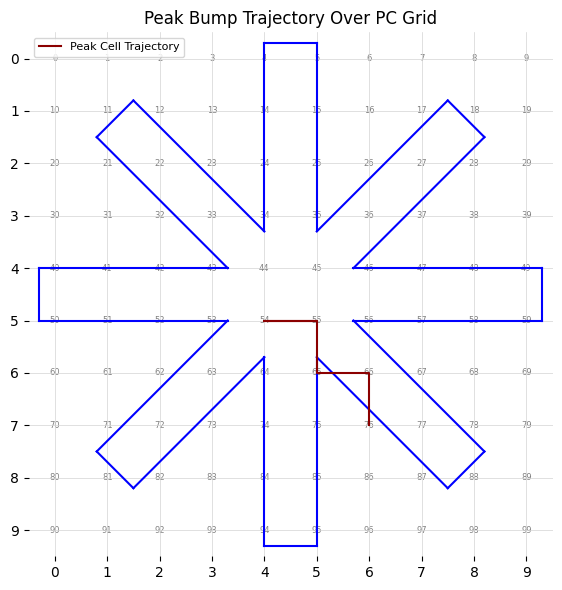

In [207]:
# Step 1: compute peak bump trajectory
peak_path = compute_bump_peak_trajectory(results)

# Step 2: plot
plot_peak_trajectory_with_maze(peak_path, PC_idx, env)